# Kunskapskontroll SQL

### Teoretiska Frågor 

# 1. Beskriv kort hur en relationsdatabas fungerar

En relationsdatabas är en typ av databas som organiserar data i tabeller (relations). 

- Tabeller är relaterade till varandra genom "primärnycklar (PRIMARY KEY)" och främmande nycklar (FOREIGN KEY).


## Exempel:

## En databas för en Restaurang 

#### Tabell: Meny
     MatID Primary Key
     Namn
     Pris

#### Tabell : Beställningar
    BäställningID PRIMARY KEY
    MatID FOREIGN KEY
    Datum

Här har Beställningar.MatID och Meny.MatID en "relation" och kan därav hämtas genom JOIN, SELECET, INSERT osv..



## 2. Vad menas med “CRUD”-flödet?

CRUD står för de fyra grundläggande operationerna i en databas:
- **Create**: Lägga till/skapa rader i en tabell
- **Read**: Läs ut och hämta data från tabeller.
- **Update**: Uppdatera existerande data.
- **Delete**: Ta bort rader från en tabell




## 3. Beskriv kort vad en “left join” och en “inner join” är

- **Inner Join**: Returnerar endast de rader som har en matchning i båda tabellerna. Matchningarna måste vara rader från vänstra och högra tabellen


-  **Left Join**: Den kombinerar rader från två tabeller, men behåller alla rader från den vänstra tabellen, även om det inte finns någon matchande rad i den högra tabellen. För de rader där det inte finns någon matchning kommer värdena i den högra tabellen att vara NULL.





## 4. Beskriv kort vad indexering i SQL innebär

- **Indexering**  används för att göra sökningar snabbare i en databas genom att minska antalet läsoperationer/göra så att databasen kan hitta specifika värden utan att behöva gå igenom alla rader 
.
- Exempel: 

        CREATE INDEX idx_kolumn ON Tabell(kolumn);


#### **5. Beskriv kort vad en vy i SQL är.**


En vy är en sparad SQL-fråga som fungerar som en virtuell tabell.



- Om man har en lång och komplicerad fråga som kan man skapa en vy för att göra det enklare att använda.
- Man kan begränsa åtkomsten till vissa data genom att skapa vyer som bara visar de delar av tabellerna som berörda användare behöver se.

#### **6. Beskriv kort vad en lagrad procedur i SQL är.**

En lagrad procedur är en uppsättning SQL-kommandon som sparas i databasen och kan köras flera gånger. Den kan ta emot parametrar och används för att återanvända kod, förbättra prestanda och säkerhet. En av funktionerna är automatiserade uppgifter, vilket innebär att den kan utföra flera SQL koder på en gång.


# SCENARIO 

## UPPGIFT 1

In [1]:
import pandas as pd 
from sqlalchemy import create_engine 
import plotly.express as px 
import streamlit as st 
import matplotlib.pyplot as plt


### 1. Skapa en Anslutning till Databasen


Stötter på problem när jag försöker skapa en anslutning enligt vad man har lärt sig från boken, märkte efter ett lite sökningar att ODBC driver 18 var ej installerad på datorn och det var ODBC driver 17. Därav behövde jag ändra koden vilket ledde till att det fungerar. 


In [2]:
engine = create_engine('mssql://@RYAN/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server')

In [3]:
connection = engine.connect() 

### 2. Lista Tabeller i Databasen

In [4]:
Query = " SELECT NAME FROM sys.tables" # sql fråga som hämtar alla tabeller i databasen
df = pd.read_sql(Query, connection) # Läser in data från SQL Server 

print(df, "\n Samtliga Tabeller i databasen")

                       NAME
0              SalesTaxRate
1          PersonCreditCard
2               PersonPhone
3            SalesTerritory
4           PhoneNumberType
..                      ...
67                 Location
68                 Password
69  SalesPersonQuotaHistory
70                   Person
71              SalesReason

[72 rows x 1 columns] 
 Samtliga Tabeller i databasen


Jag behövde veta vilka tabeller tillhörde vilka scheman så jag utförde en inner join från tables tillsammans med schemas nedan för att få denna resultat. Fast jag kunde enkelt ha kollat under databasen > tabeller i MSSQL. Detta gör jag för att kunna utföra uppgiften där jag ska demonstrera intressanta aspekter av datan.

Problemet jag stöttade på här var att eftersom VSCODE inte skrev ut alla rader, behövde jag filtrera ut de tabeller jag inte ville göra något med.. tog mig ett tag för att veta om jag behöver använda s.name eller t.name efter WHERE, samt så testade jag med WHERE s.name =! 'dbo', 'HumanResources', vilket gjorde så att jag endast kunde filtrera bort dbo schemat och inga fler.. till slut kom jag fram till resultatet nedan där jag fick använda NOT IN.

In [5]:
QUERY = """
SELECT s.name AS SchemaName, t.name AS TableName
FROM sys.tables AS t
INNER JOIN sys.schemas AS s
ON t.schema_id = s.schema_id
WHERE s.name NOT IN ('dbo', 'Person')
ORDER BY s.name, t.name;
"""
df_filtered = pd.read_sql(QUERY, connection)

print(df_filtered, "\n Lista över schema.tabeller utan 'dbo' och 'Person'")



        SchemaName                              TableName
0   HumanResources                             Department
1   HumanResources                               Employee
2   HumanResources              EmployeeDepartmentHistory
3   HumanResources                     EmployeePayHistory
4   HumanResources                           JobCandidate
5   HumanResources                                  Shift
6       Production                        BillOfMaterials
7       Production                                Culture
8       Production                               Document
9       Production                           Illustration
10      Production                               Location
11      Production                                Product
12      Production                        ProductCategory
13      Production                     ProductCostHistory
14      Production                     ProductDescription
15      Production                        ProductDocument
16      Produc

Här skriver jag ut samtliga kolumner som finns i tabellen jag har valt "HumanResources.Employee" , jag valde just employee då namnet syftar på anställda och där brukar anställnings plats vara med och den informationen vill jag ha då jag vill få fram uppgifterna som uppgift 1 gav som exempel för att analysera.

Problemet jag stötta på här var att jag hade för mig att WHERE HumanResources.Employee bör fungerat men där fick jag en error.. Efter lite sökning fram och tillbaka , insåg jag att man behöver specificera Table_NAME och schema separat. 

In [6]:
query = """
SELECT COLUMN_NAME
FROM INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = 'Employee' AND TABLE_SCHEMA = 'HumanResources';
"""
df_employee_columns = pd.read_sql(query, connection) # df används för att läsa in data från SQL Server och står för data frame

print(df_employee_columns, "\n Kolumner i HumanResources.Employee")

          COLUMN_NAME
0    BusinessEntityID
1    NationalIDNumber
2             LoginID
3    OrganizationNode
4   OrganizationLevel
5            JobTitle
6           BirthDate
7       MaritalStatus
8              Gender
9            HireDate
10       SalariedFlag
11      VacationHours
12     SickLeaveHours
13        CurrentFlag
14            rowguid
15       ModifiedDate 
 Kolumner i HumanResources.Employee


Nedan väljer jag några kolumner som jag ville skriva ut, där bland JobTitle, Birthdate, Gender, HireDate

Dessa är intressanta då jag anser det är dessa delar av datan jag vill använda för att analysera 

In [7]:

query = """ 
SELECT JobTitle, BirthDate, Gender, HireDate
FROM HumanResources.Employee; 
"""
df = pd.read_sql(query, connection)

print(df)

                          JobTitle   BirthDate Gender    HireDate
0          Chief Executive Officer  1969-01-29      M  2009-01-14
1    Vice President of Engineering  1971-08-01      F  2008-01-31
2              Engineering Manager  1974-11-12      M  2007-11-11
3             Senior Tool Designer  1974-12-23      M  2007-12-05
4                  Design Engineer  1952-09-27      F  2008-01-06
..                             ...         ...    ...         ...
285           Sales Representative  1977-02-14      F  2013-05-30
286         European Sales Manager  1957-09-20      F  2012-04-16
287           Sales Representative  1975-07-09      F  2013-05-30
288           Sales Representative  1968-03-17      F  2012-05-30
289           Sales Representative  1975-09-30      M  2012-05-30

[290 rows x 4 columns]


### 3. Hämta och Analysera Data från en Tabell


Med hjälp av Streamlit och instruktionerna i boken, skapar jag en visualisering av datan över Arbetstittel och antalet anställda per arbetstitell. Jag behövde använda en .py (python filformat) och eftersom jag har kört alla dessa koder i ipynb (Jupyter Notebook fil), behövde jag köra nedan kod I egen fält. Jag demonstrar koden nedan ändå men den behövde köras i en annan.

För att kunna slutföra den behövde jag även köra streamlit run (filnamnet.py) i terminalen för att sedan få ut resultatet.

Jag funderade över att göra visualiseringen genom matplotlib men eftersom boken handlade om Streamlit, så valde jag detta istället.

In [ ]:
query = """
SELECT TOP 10 JobTitle, COUNT(*) AS Antal  
FROM HumanResources.Employee
GROUP BY JobTitle
ORDER BY Antal DESC;
"""

df = pd.read_sql(query, con=engine)

# Förbereda data för visning och filtrering
st.title("Overview of Job Titles")
st.write("This app displays the top 10 job titles from the AdventureWorks2022 database.")

unique_titles = df['JobTitle'].unique() # filtrerar unika jobbtitlar
selected_title = st.selectbox("Filter by Job Title", options=unique_titles, index=0) # skapar en selectbox för att filtrera data

if selected_title == "All Titles": # om man väljer "All Titles" visas alla jobbtitlar
    filtered_df = df 
else:
    filtered_df = df[df['JobTitle'] == selected_title] # annars visas endast den valda jobbtiteln

# Visa filtrerad data som tabell
st.dataframe(filtered_df.style.format({"Antal": "{:.0f}"}))

# Skapa och visa ett stapeldiagram
fig = px.bar(
    filtered_df,
    x="JobTitle",
    y="Antal",
    title=f"Antal per Job Title: {selected_title if selected_title != 'All Titles' else 'All Titles'}",
    labels={"JobTitle": "Job Title", "Antal": "Number of Employees"},
    color="JobTitle",
    barmode="group"
)
st.plotly_chart(fig)


## Analysera datan och resultaten du tagit fram. Vilka slutsatser och rekommendationer kan du ge?

- **Slutsatser**:

Enligt den data som jag har fått fram angående antalet anställda på företaget kan jag se att majoritet av anställda har jobbtiteln Production Technician.
Detta kan vara en indikation på att det är en stor del av anställda som jobbar med produktion på företaget. 
Där man även kan se att de arbetstittlar som ej är produktionsrelaterade är i minoritet. Av dessa är Sales representive, buyer och marketing specialist.

Detta indikera att produktion är en stor del av företagets verksamhet och att försäljning eller marknadsföring inte har lika stor fokus.

**Rekomendationer**:

- För att utöka företagets förmåga att sälja produkter och tjänster kan det vara bra att överväga att anställa fler säljare eller marknadsförare.

- Man kan även se över automatisering av produktionen för att minska behovet av arbetskraften. Detta kan leda till att företaget kan sälja mer produkter och tjänster och därmed öka sin omsättning.



Jag insåg ganska sent efter att ha gjort allt ovan att kraven för G-Nivå är: **Vi ser att männen i företaget är i snitt 45 år gamla och tjänar 34 400 kr medan kvinnorna i snitt är 37 år gamla och har en medellön på 40 200 kr.**

Därav började jag ta fram (med hjälp av MSSQL), vilka databaser inehåller den information jag behöver för att komma fram till resultatet. Ganska fort så hittade jag HumanResources.Employee och HumanResources.EmployeePayHistory.

Kolumnerna jag behövde använda var enligt nedan. Jag fick väldigt mycket svårigheter i att omvandla Birthdate till ålder, därav började jag med att leta fram en databas som möjligt hade alla åldrar redan uträknade, men lyckades tyvärr inte.

Sedan hittade jag online att jag behövde omvanda BirthDate till ett format som pandas kan läsa och sedan använda det för att räkna ut datumet från birth fram till dagensdatum. 

Jag ska vara ärlig med att jag tog hjälp av GitHub för att komma på hur jag ska utföra grupperingarna då jag försökte köra grouped = df.grupby(['BirthDate, 'Gender'] ['Rate']) men detta fungerade inte bra då BirthDate tog med alla möjliga datum och grafen blev kaotiskt.



C:\Users\RyanL\AppData\Local\Temp\ipykernel_14852\3937683732.py:21: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



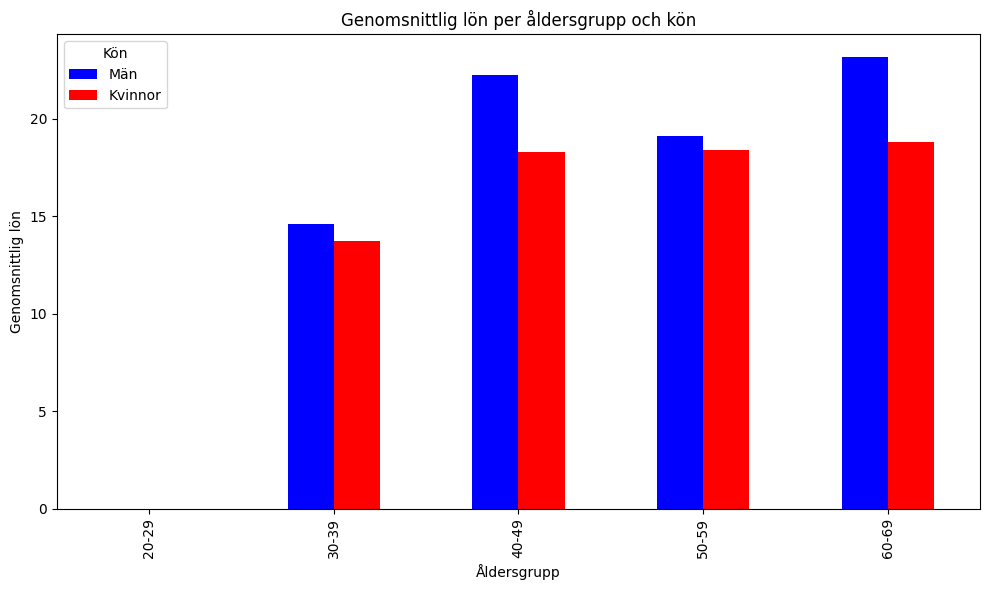

In [ ]:
# Hämta data från EmployeePayHistory och Employee
query_employee_pay = """
SELECT 
    A.BusinessEntityID,
    A.Rate,
    B.Gender,
    B.BirthDate
FROM HumanResources.EmployeePayHistory AS A
INNER JOIN HumanResources.Employee AS B
ON A.BusinessEntityID = B.BusinessEntityID
"""
with engine.connect() as connection:
    df = pd.read_sql(query_employee_pay, connection)

df['BirthDate'] = pd.to_datetime(df['BirthDate']) 
df['Age'] = (pd.to_datetime("today") - df['BirthDate']).dt.days / 365 

df['AgeGroup'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 70], labels=['20-29', '30-39', '40-49', '50-59', '60-69'])


grouped = df.groupby(['AgeGroup', 'Gender'])['Rate'].mean().unstack()  

#Med hjälp av matliplot skapar jag en stapeldiagram (bar char)

grouped.plot(kind='bar', figsize=(10, 6), color=['blue', 'red'])


plt.title("Genomsnittlig lön per åldersgrupp och kön")
plt.xlabel("Åldersgrupp")
plt.ylabel("Genomsnittlig lön")
plt.legend(title="Kön", labels=["Män", "Kvinnor"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


 ## **Självvärdering*
 
 **1. Utmaningar du haft under arbetet samt hur du hanterat dem.**

    Jag har haft utmaningar med att komma ihåg allt man har lärt sig.. och hur man ska använda det man har lärt sig. Som tur är att när jag gick igenom boken så tog jag väldigt mycket anteckningar och testade egna koder. Detta har varit till stor hjälp för att jag kunde bättre komma ihåg och visualisera hur programmeringen såg ut. Samtidigt dem flesta problemen hanterade genom att gå till boken och mina anteckningar för att fräscha upp minnet 
    Något jag känner var väldigt utmanande att implantera SQL med Python. Detta tycker jag var väldigt lite av i boken och boken visade endast hur koderna gick till i slutet på en kapitel. Jag tycker det fanns väldigt lite hjälp för att felsöka och felhantera. För att komma förbi denna svårighet fick jag gå igenom en del av mina gamla anteckningar från python utbildningen.

 **2. Vilket betyg du anser att du skall ha och varför.**

    Jag anser att jag ligger på G-nivå. Detta för att jag har haft en hel del utmaningar som jag egentligen överkom till slut, men detta ledde till att jag inte hade möjligheten att fördjupa mig yttligare till den nivån med mina koder som jag egentligen hade önskat..

 **3. Tips du hade gett till dig själv i början av kursen nu när du slutfört den.**

    Jag känner att jag satte mig med alla koder från boken och skrev egna koder utifrån dem, samt felsökte och fördjupade mig i att förstå dem redan från första kapitlarna.. detta tog väldigt mycket av min tid och gjorde det svårare för mig att komma vidare då jag hängde upp mig på små saker. Jag hade nog kört på lite mer och repeterat efteråt istället för att fastna, felsöka och fördjupa redan i början.